In [ ]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('../src')

import numpy as np
from utils import adata_train

In [6]:
from tqdm import tqdm
import pandas as pd

import celloracle as co
oracle = co.data.load_tutorial_oracle_object()

In [10]:
import spaceoracle

so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='rctd_cluster', 
    max_epochs=15, 
    learning_rate=7e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='zeros',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True,
)


None
🌍️ Generating spatial 64x64 maps...


In [11]:
import copy 

so.adata = copy.deepcopy(oracle.adata)
so.pcs, so.pca = so.perform_PCA(so.adata)
so.knn_imputation(so.adata, so.pcs)
so.gene2index = dict(zip(
                so.adata.var_names, 
                range(len(so.adata.var_names))
            ))


In [12]:
so.embedding_name = 'X_draw_graph_fa'
so.embedding = so.adata.obsm['X_draw_graph_fa']
so.cluster_column_name = 'louvain'

In [13]:
from celloracle.applications import Pseudotime_calculator

pt = Pseudotime_calculator(oracle_object=so)

In [14]:
# Instantiate pseudotime object using anndata object.
pt = Pseudotime_calculator(adata=so.adata,
                           obsm_key=so.embedding_name, # Dimensional reduction data name
                           cluster_column_name=so.cluster_column_name # Clustering data name
                           )

45


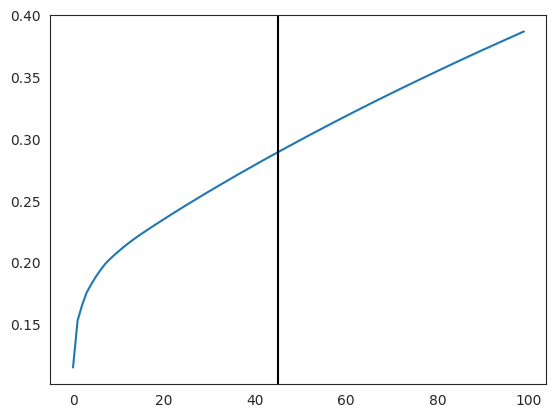

In [15]:
# Select important PCs
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc 

plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [16]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :2671
Auto-selected k is :66


In [17]:
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

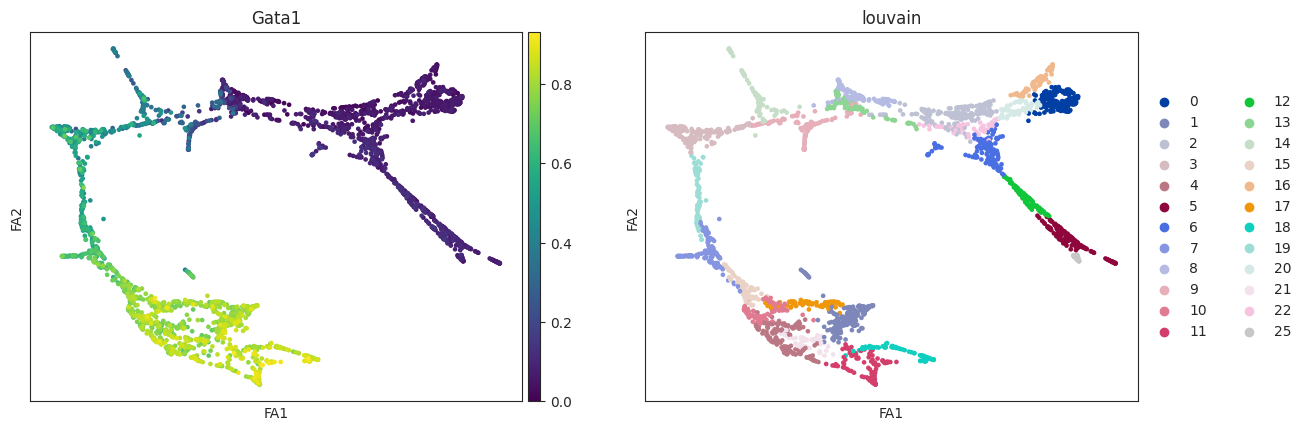

In [18]:
# Check gene expression 
import scanpy as sc 

goi = "Gata1"
sc.pl.draw_graph(so.adata, color=[goi, so.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

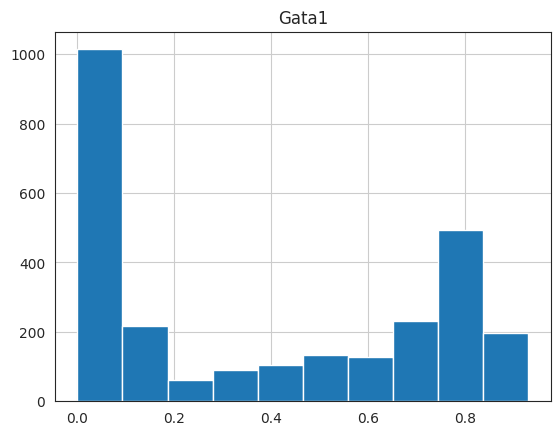

In [19]:
# Plot gene expression in histogram
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [20]:
# need cell oracle coef_matrix

links = co.data.load_tutorial_links_object()
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/24 [00:00<?, ?it/s]

In [60]:
# Construct coef for each cell (gene x gene x cell)
betas_dict = {}

for i, cell_cluster in enumerate(list(so.adata.obs['louvain_annot'])):
    cell_coef = oracle.coef_matrix_per_cluster[cell_cluster]
    betas_dict[i] = cell_coef
    
len(betas_dict)

2671

In [61]:
so.beta_dict = betas_dict
so.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

Running simulation 3/3: 100%|██████████| 2671/2671 [00:04<00:00, 575.08it/s]


In [62]:
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [63]:
np.allclose(oracle.adata.layers['delta_X'], so.adata.layers['delta_X'])

False

In [64]:
np.allclose(so.adata.layers['normalized_count'], so.adata.layers['delta_X'])

False

In [65]:
oracle.adata.layers['delta_X']

array([[-2.01290315e-05,  1.59353567e-02,  4.95181210e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.41063066e-08,  4.04961339e-05,  5.87056623e-08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.84684868e-05, -2.19007477e-04, -2.14351304e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.21772984e-05,  1.75568885e-02,  5.45569291e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.18341445e-08,  5.41124981e-06, -1.30747380e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.20560093e-06, -3.38173873e-06, -1.40611081e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [66]:
so.adata.layers['delta_X']

array([[-0.11678527, -0.4800138 , -0.26922702, ..., -0.3618107 ,
        -0.24910285, -0.05067114],
       [-0.3129289 , -0.23153684,  0.0223696 , ..., -0.06550126,
        -0.0381675 , -0.083397  ],
       [ 0.11168515,  0.08519167,  0.16556681, ...,  0.16668189,
         0.2092016 , -0.00349727],
       ...,
       [-0.07842101,  0.97958434, -0.28102156, ..., -0.20759812,
        -0.33377604,  0.        ],
       [ 0.54435578,  0.25800565,  0.7439962 , ..., -0.163943  ,
        -0.0168678 , -0.04024379],
       [-0.29189424, -0.00707827,  0.04543875, ..., -0.16904698,
        -0.09482579,  0.27124477]])

In [67]:
so.adata.layers['delta_X'] = so.adata.layers['delta_X']

so.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

In [68]:
so.calculate_embedding_shift(sigma_corr=0.05)

/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/numpy/linalg/linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


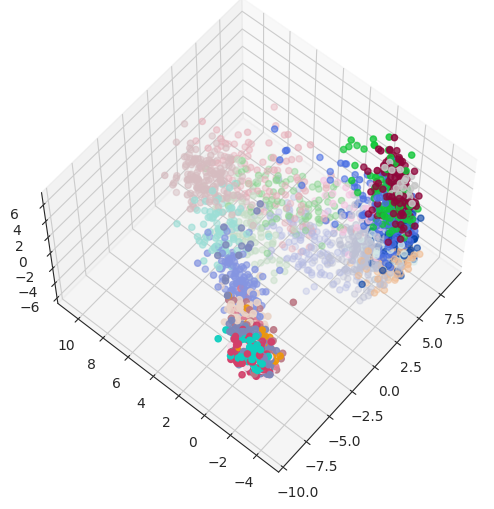

In [69]:
so.plot_pca()

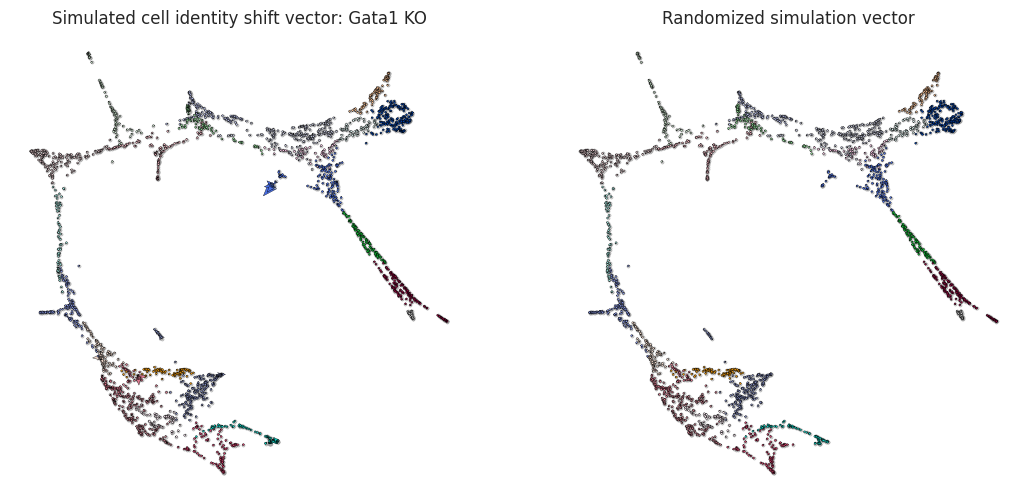

In [70]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [71]:
# n_grid = 40 is a good starting value.
n_grid = 40 
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

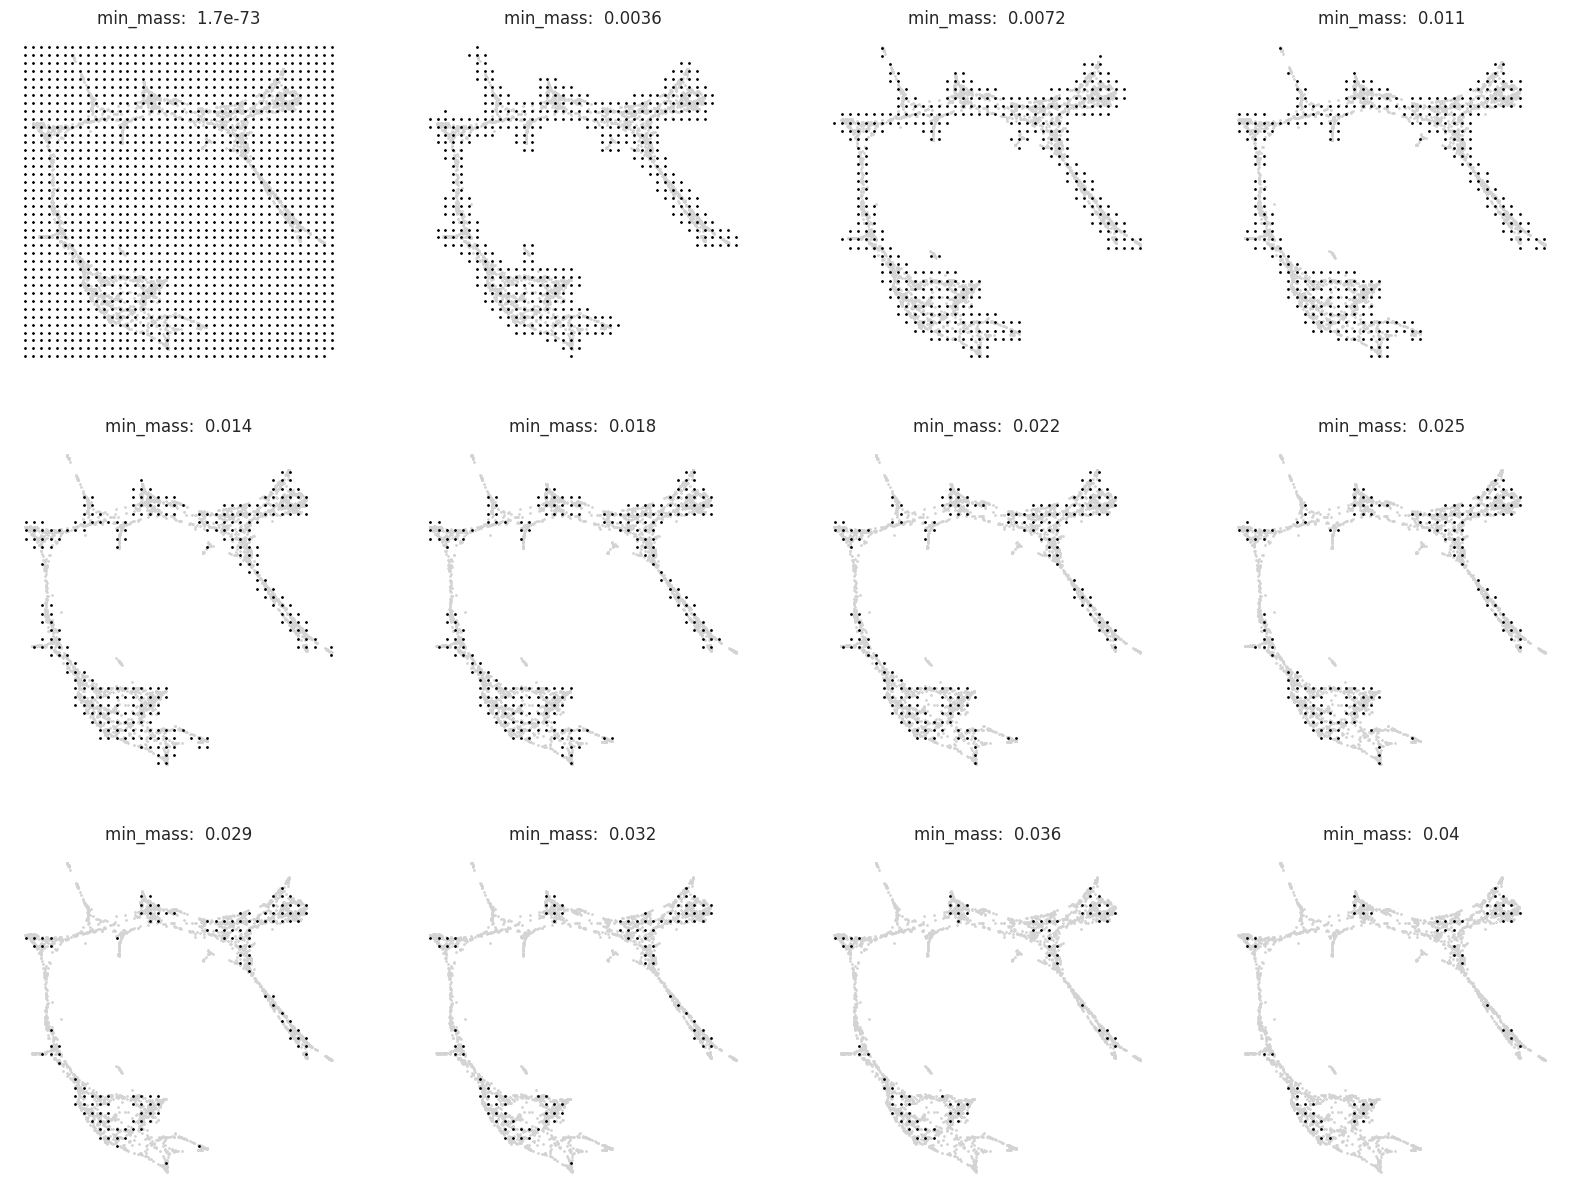

In [72]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

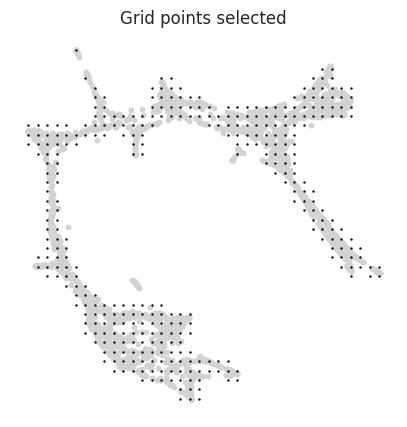

In [73]:
min_mass = 0.01
so.calculate_mass_filter(min_mass=min_mass, plot=True)

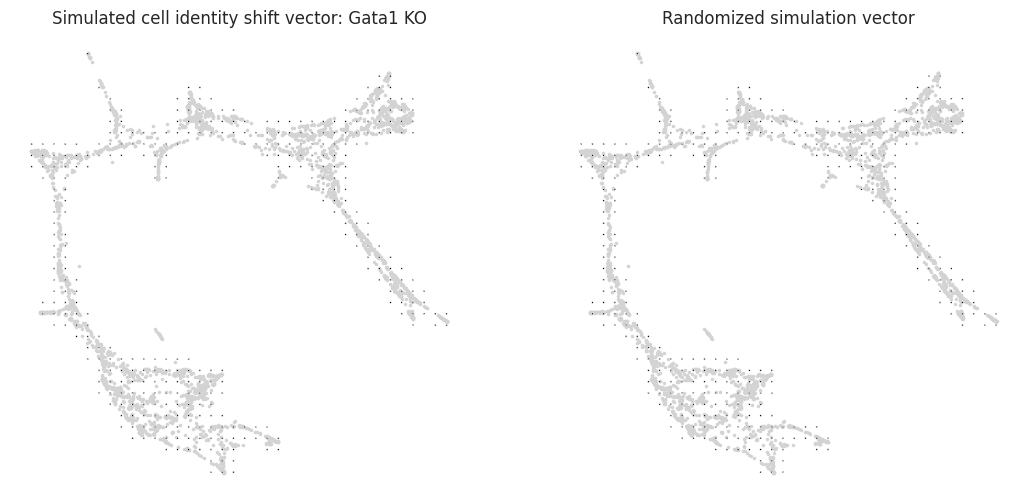

In [74]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

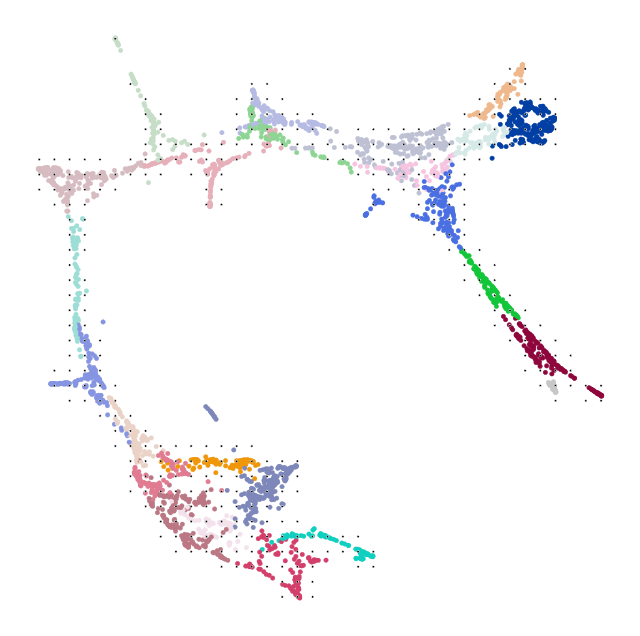

In [75]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)